##Predicting Sunspots with Neural Networks (DNN Only)

Train the model on the `Sunspots` dataset. This is monthly record of sunspot numbers from 1749 to 2018

The first network will be composed of dense layers. This will serve as a baseline to compare against more complex architecture

##Imports 
Use the same imports as before with an addition of the csv module

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

##Plotting Utilities

In [3]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

##Download and Preview the Dataset

In [4]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2022-06-20 23:29:38--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-06-20 23:29:38 (132 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



Running the cell below, you'll see that there are only three columns in the dataset:

1. untitled column containing the month number
2. Date which has the format YYYY-MM-DD
2. Mean Total Sunspot Number

In [5]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


For the following lab, only the month number and the average total sunspot numbers will be used. They will be loaded into memory and converted into arrays that represent time series 

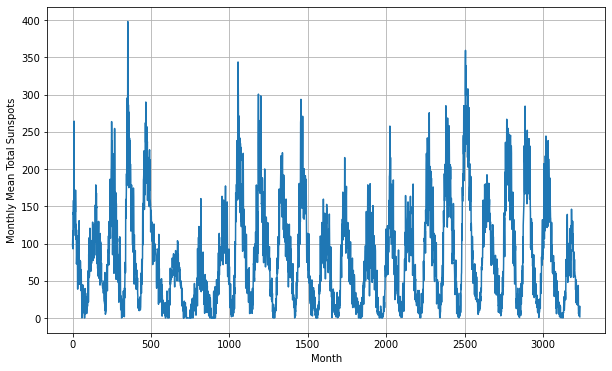

In [6]:
#Initialize lists
time_step = []
sunspots = []

#Open CSV file
with open('./Sunspots.csv') as csvfile:
  
  #Initialize reader
  reader = csv.reader(csvfile,delimiter = ',')

  #Skip the first line
  next(reader)

  #Append row and sunspot number to list
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

#Convert lists to numpy arrays 
time = np.array(time_step)
series = np.array(sunspots)

#Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspots')

##Split the Dataset

There are 3235 points in the dataset and the first 3000 will be used for training

In [7]:
#Define the split time 
split_time = 3000

#Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

#Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

##Prep Features and Labels 
The window size is set to 30 and that is 2.5 years 

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows 

  Args:
    series (array of float) - contains the values of the time series 
    window_size (int) - the number of time steps to include in the feature 
    batch_size (int) - the size of the batches that'll be fed into the model 
    shuffle_buffer (int) - buffer size to use for the shuffle method 

  Returns:
    dataset (TF Dataset) - TF Dataset containing time windows 
  """

  #Generate a TF Dataset from the series values 
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with the specified size 
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)

  #Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  #Create tuples with features and labels
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  #Create batches of windows 
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [9]:
#Parameters 
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

#Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

##Build the Model

3-Layer Dense Network 

In [10]:
#Build the model 
model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(30, input_shape=[window_size], activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________


##Tune the Learning Rate 

In [12]:
#Set the learning rate scheduler 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

#Set the training parameters 
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

#Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 2s 13ms/step - loss: 33.0724 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 10ms/step - loss: 32.8283 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 6ms/step - loss: 32.5721 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 5ms/step - loss: 32.3018 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 6ms/step - loss: 32.0190 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 6ms/step - loss: 31.7258 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 5ms/step - loss: 31.4240 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 8ms/step - loss: 31.1173 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 7ms/step - loss: 30.8078 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 7ms/step - loss: 30.4979 - lr: 2.8184e-08
Epoch 11/100
93/9

(1e-05, 0.0001, 0.0, 100.0)

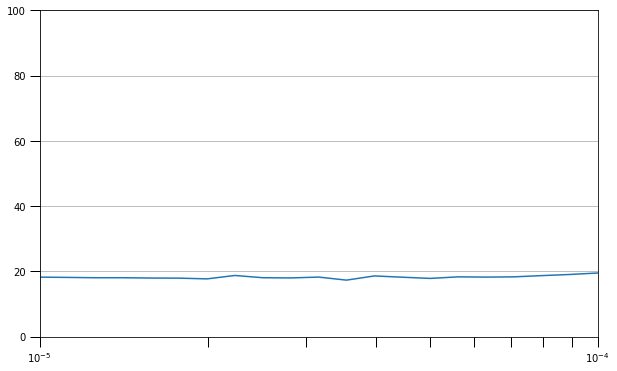

In [15]:
#Define the learning rate array 
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

#Set the figure size
plt.figure(figsize = (10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log sclae 
plt.semilogx(lrs, history.history['loss'])

#Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

#Set the plot boundaries 
plt.axis([1e-5, 1e-4, 0, 100])

Lookw like 10^-5 is optimal

##Train the Model 

In [16]:
#Reset states generated by keras 
tf.keras.backend.clear_session()

#Build the model
model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(30, input_shape=[window_size], activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1)
])


In [17]:
#Set the learning rate
learning_rate = 2e-5

#Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

#Set the training parameters 
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

#Train the model
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 2s 10ms/step - loss: 34.4456 - mae: 34.9412
Epoch 2/100
93/93 [==============================] - 1s 10ms/step - loss: 20.3534 - mae: 20.8459
Epoch 3/100
93/93 [==============================] - 1s 11ms/step - loss: 19.6867 - mae: 20.1799
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 19.1348 - mae: 19.6268
Epoch 5/100
93/93 [==============================] - 1s 6ms/step - loss: 18.8514 - mae: 19.3435
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 18.5748 - mae: 19.0673
Epoch 7/100
93/93 [==============================] - 1s 6ms/step - loss: 18.3295 - mae: 18.8219
Epoch 8/100
93/93 [==============================] - 1s 7ms/step - loss: 18.1809 - mae: 18.6724
Epoch 9/100
93/93 [==============================] - 1s 7ms/step - loss: 18.0296 - mae: 18.5217
Epoch 10/100
93/93 [==============================] - 1s 6ms/step - loss: 17.8132 - mae: 18.3048
Epoch 11/100
93/93 [================

##Model Prediction

In [19]:
def model_forecast(model, series, window_size, batch_size):
  """
  Uses an unput model to generate predictions on data windows 

  Args:
    model (TF Keras Model) - model that accepts data windows 
    series (array of float) - contains the values of the time series 
    window_size (int) - the number of time steps to include in the window 
    batch_size (int) - the batch size

  Returns:
    forecast (numpy array) - array containing predictions
  """

  #Generat a TF Dataset from the series values 
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with the specified size 
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)

  #Flatten the windows by putting its elements in a single batch 
  dataset = dataset.flat_map(lambda w: w.batch(window_size))

  #Create batches of windows 
  dataset = dataset.batch(batch_size).prefetch(1)

  #Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast

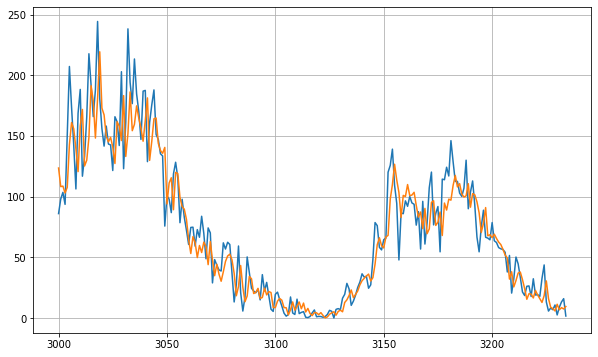

In [20]:
#Reduce the original series
forecast_series = series[split_time-window_size: -1]

#Use helper function to generate predictions 
forecast = model_forecast(model, forecast_series, window_size, batch_size)

#Drop single dimensional axis
results = forecast.squeeze()

#Plot the results 
plot_series(time_valid, (x_valid, results))

In [21]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())


14.838844
